In [1]:
from tensorflow_addons.metrics import F1Score
from tensorflow.python.ops.losses.losses_impl import softmax_cross_entropy
from keras_nlp.layers import TransformerEncoder

import keras.models

model_path = r'..\archive\encoder_block_h0_p0_test\22-10-29_20-37-34_encoder_block_h0_p0\model'
model = keras.models.load_model(model_path,custom_objects={'F1Score':F1Score})
model.summary()

D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)
D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\keras\initializers\initializers_v2.py:121: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 15)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 10, 15)      30          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 embedding (Dense)              (None, 10, 8)        128         ['layer_normalization[0][0]']    
                                                                                                  
 sine_position_encoding (SinePo  (None, 10, 8)       0           ['embedding[0][0]']          

In [2]:
import numpy as np

x_test = np.load(r'D:\Egyetem\7.Semester\CryptoPredictions\splits\test\x_preprocessed_h0_p0.npy')
y_test = np.load(r'D:\Egyetem\7.Semester\CryptoPredictions\splits\test\y_preprocessed_h0_p0.npy')
print(x_test.shape)
y_test.shape

(552, 10, 15)


(552, 2)

In [3]:
layer_norm = model.get_layer('layer_normalization')
embedding = model.get_layer('embedding')
sine_position_encoding = model.get_layer('sine_position_encoding')
add = model.get_layer('add')
transformer_encoder = model.get_layer('transformer_encoder')

In [4]:
normed = layer_norm(x_test)
embedded = embedding(normed)
encodings = sine_position_encoding(embedded)
PEembedding = add([embedded,encodings])

In [5]:
PEembedding.numpy().shape

(552, 10, 8)

In [6]:
encoder = model.get_layer('transformer_encoder')
att_layer = encoder._multi_head_attention_layer
output_tensor,scores = att_layer(PEembedding.numpy(),PEembedding.numpy(),return_attention_scores=True,training=False)

In [7]:
output_tensor.shape

TensorShape([552, 10, 8])

In [8]:
scores.shape

TensorShape([552, 3, 10, 10])

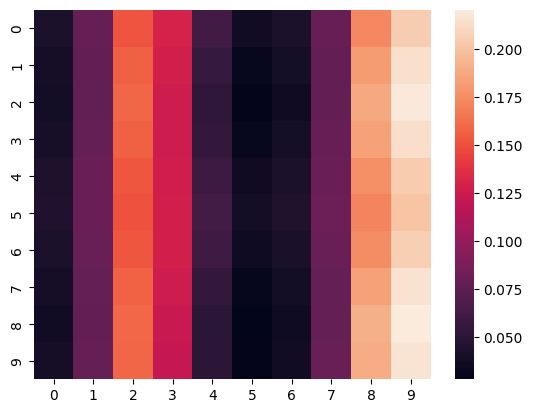

In [9]:
import seaborn as sns
ax = sns.heatmap(scores[0][0])

In [10]:
averaged_attentions = np.average(scores.numpy(),axis=0)
averaged_attentions.shape


(3, 10, 10)

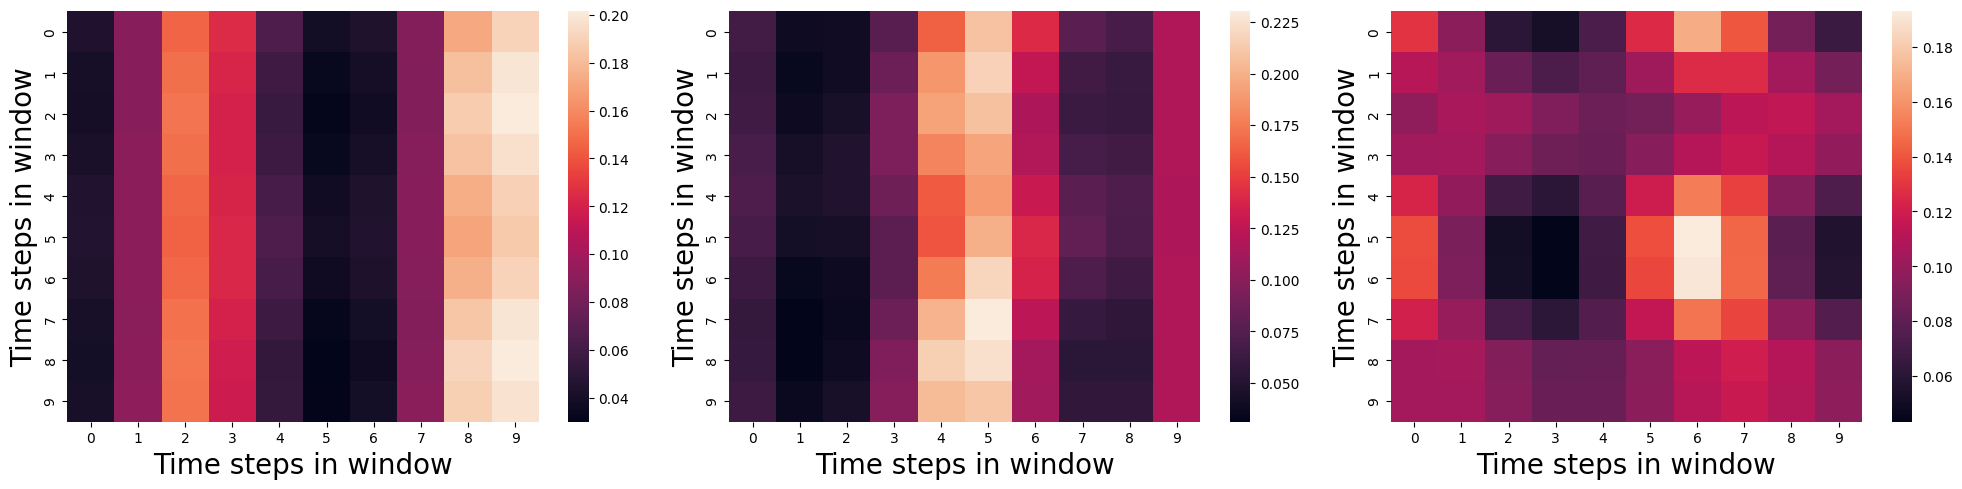

In [13]:
from matplotlib import pyplot as plt

fig,axes = plt.subplots(ncols=3,figsize=(20,5))
for idx,ax in enumerate(axes):
    sns.heatmap(averaged_attentions[idx],ax=ax)
    ax.set_ylabel('Time steps in window',fontsize=20)
    ax.set_xlabel('Time steps in window',fontsize=20)
plt.tight_layout()
plt.savefig('../documents/figures/self_att_annotated.png')


<AxesSubplot:>

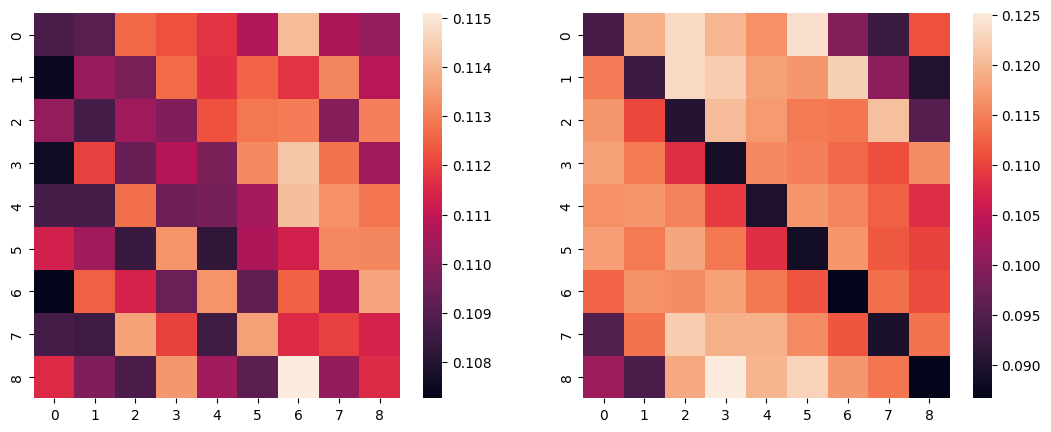

In [27]:
import seaborn as sns
fig,axes = plt.subplots(ncols=2,figsize=(13,5))
sns.heatmap(averaged_attentions[0],ax = axes[0])
sns.heatmap(averaged_attentions[1],ax = axes[1])